# Name: Pragya Shukla
# Roll No: MDS202027
## TDA Assignment 3

### Task

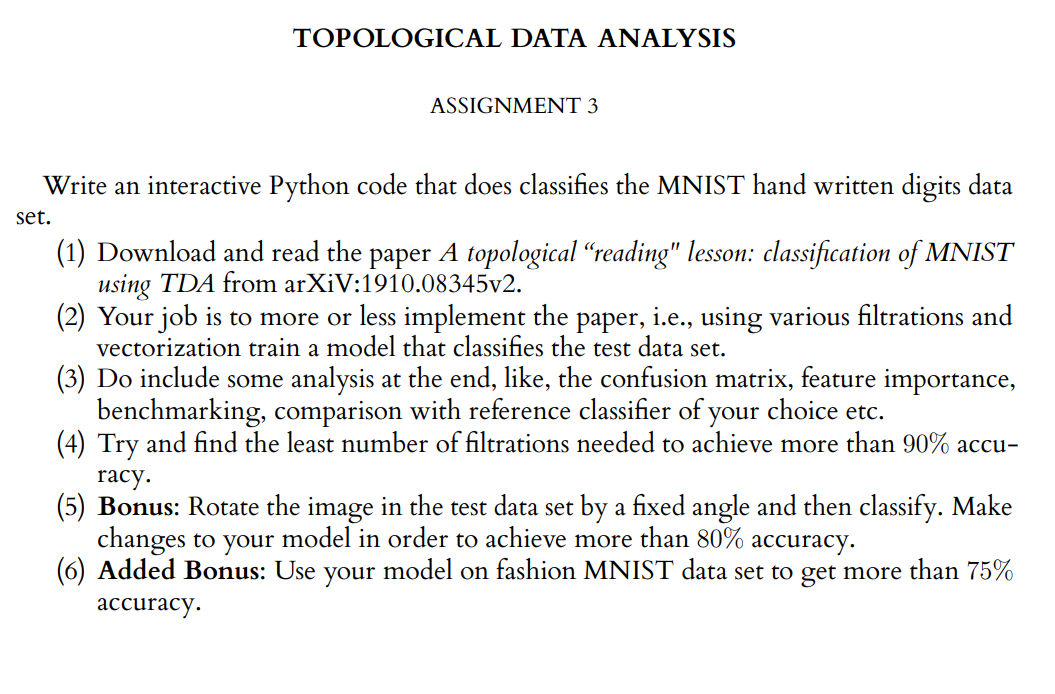

## Steps

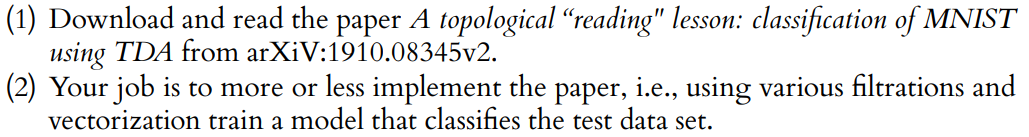

**We have used the MNIST dataset, which contains images of handwritten digits and is a standard benchmark for testing new classification algorithms.**

**1. Load Dataset**

In [66]:
from sklearn.datasets import fetch_openml
import numpy as np

X, y = fetch_openml("mnist_784", version=1, return_X_y=True)

**2. Print the shape**

In [67]:
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (70000, 784), y shape: (70000,)


**3. Split to train-test dataset**

We will train on 500 rows in place of whole dataset and test on 50 rows.

In [68]:
from sklearn.model_selection import train_test_split

train_size, test_size = 500, 50

# Reshape to (n_samples, n_pixels_x, n_pixels_y)
X = X.values.reshape((-1, 28, 28))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=666
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (500, 28, 28), y_train shape: (500,)
X_test shape: (50, 28, 28), y_test shape: (50,)


**4. From pixels to topological features**

Several steps are required to extract topological features from an image. Since our images are made of pixels, it is convenient to use filtrations of cubical complexes instead of simplicial ones. We will go through each of these steps for a single “8” digit using giotto-tda.

**Binarize the image**

In giotto-tda, filtrations of cubical complexes are built from binary images consisting of only black and white pixels. We can convert our greyscale image to binary by applying a threshold on each pixel value via the Binarizer transformer:

In [69]:
from gtda.images import Binarizer

# Pick out index of first 8 image
im8_idx = np.flatnonzero(y_train == "8")[0]
# Reshape to (n_samples, n_pixels_x, n_pixels_y) format
im8 = X_train[im8_idx][None, :, :]

binarizer = Binarizer(threshold=0.4)
im8_binarized = binarizer.fit_transform(im8)

binarizer.plot(im8_binarized)

**From binary image to filtration**

Now that we have a binary image  of “8” digit, we will build a wide variety of different filtrations. We’ll use the radial filtration first, which assigns to each pixel  a value corresponding to its distance from a predefined center  of the image

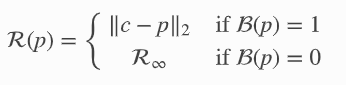

where  is the distance of the pixel that is furthest from <i>c</i>. To reproduce the filtered image from the MNIST article, we’ll pick <i>c</i> = (20,6):

In [70]:
from gtda.images import RadialFiltration

radial_filtration = RadialFiltration(center=np.array([20, 6]))
im8_filtration = radial_filtration.fit_transform(im8_binarized)

radial_filtration.plot(im8_filtration, colorscale="jet")

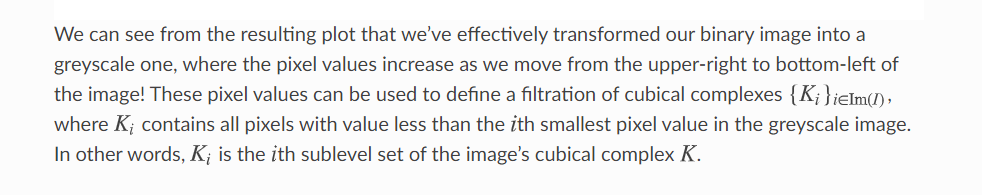

**From filtration to persistence diagram**

Given a greyscale filtration it is straightforward to calculate the corresponding persistence diagram. In giotto-tda we make use of the CubicalPersistence transformer which is the cubical analogue to simplicial transformers like VietorisRipsPersistence:

In [71]:
from gtda.homology import CubicalPersistence

cubical_persistence = CubicalPersistence(n_jobs=-1)
im8_cubical = cubical_persistence.fit_transform(im8_filtration)

cubical_persistence.plot(im8_cubical)

It works! We can clearly see two persistent  generators corresponding to the loops in the digit “8”.

As a postprocessing step, it is often convenient to rescale the persistence diagrams which can be achieved in giotto-tda as follows:

In [72]:
from gtda.diagrams import Scaler

scaler = Scaler()
im8_scaled = scaler.fit_transform(im8_cubical)

scaler.plot(im8_scaled)

**From persistence diagram to representation**

The final step is to define a vectorial representation of the persistence diagram that can be used to obtain machine learning features. We will convolve our persistence diagram with a Gaussian kernel and symmetrize along the main diagonal, a procedure achieved via the HeatKernel transformer:

In [73]:
from gtda.diagrams import HeatKernel

heat = HeatKernel(sigma=.15, n_bins=60, n_jobs=-1)
im8_heat = heat.fit_transform(im8_scaled)

# Visualise the heat kernel for H1
heat.plot(im8_heat, homology_dimension_idx=1, colorscale='jet')

**Combining all steps as a single pipeline**

We will combine all above steps as a single scikit-learn pipeline:

In [74]:
from sklearn.pipeline import Pipeline
from gtda.diagrams import Amplitude

steps = [
    ("binarizer", Binarizer(threshold=0.4)),
    ("filtration", RadialFiltration(center=np.array([20, 6]))),
    ("diagram", CubicalPersistence()),
    ("rescaling", Scaler()),
    ("amplitude", Amplitude(metric="heat", metric_params={'sigma':0.15, 'n_bins':60}))
]

heat_pipeline = Pipeline(steps)
im8_pipeline = heat_pipeline.fit_transform(im8)
im8_pipeline

array([[0.57234335, 2.49781365]])

In the final step we’ve used the Amplitude transformer to “vectorize” the persistence diagram via the heat kernel method above. In this, it produces a vector of amplitudes where each amplitude corresponds to a given homology dimension in the persistence diagram. By extracting these feature vectors from each image, we can feed them into a machine learning classifier.

**Additional: Building a full feature extraction pipeline**

We will make extracting topological features for a single image more realistic and extract a wide variety of features over the whole training set. The resulting pipeline resembles the figure below, where different filtrations and vectorizations of persistence diagrams can be concatenated to produce informative feature vectors.

To keep things simple, we have augmented our radial filtration with a height filtration $H$, defined by choosing a unit vector  in some direction and assigned values  based on the distance of <i>p</i> to the hyperplane defined by <i>v</i>. We have picked a uniform set of directions and centers for our filtrations.

We have also generated features from persistence diagrams by using persistence entropy and a broad set of amplitudes. Putting it all together yields the following pipeline:

In [75]:
from sklearn.pipeline import make_pipeline, make_union
from gtda.diagrams import PersistenceEntropy
from gtda.images import HeightFiltration

direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]

center_list = [
    [13, 6],
    [6, 13],
    [13, 13],
    [20, 13],
    [13, 20],
    [6, 6],
    [6, 20],
    [20, 6],
    [20, 20],
]

# Creating a list of all filtration transformer, we will be applying
filtration_list = (
    [
        HeightFiltration(direction=np.array(direction), n_jobs=-1)
        for direction in direction_list
    ]
    + [RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
)

# Creating the diagram generation pipeline
diagram_steps = [
    [
        Binarizer(threshold=0.4, n_jobs=-1),
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1),
    ]
    for filtration in filtration_list
]

# Listing all metrics we want to use to extract diagram amplitudes
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

#
feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)]
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)

In [76]:
X_train_tda = tda_union.fit_transform(X_train)
X_train_tda.shape

(500, 476)

**5. Training a classifier**

We see we have generated  topological features per image. In general, some of these features will be highly correlated and a feature selection procedure could be used to select the most informative ones. We will now train a Random Forest classifier on our training set to see what kind of performance we can get:

**<ol>Random Forest**

In [77]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)

X_test_tda = tda_union.transform(X_test)
ran_pred = rf.predict(X_test_tda)

rf.score(X_test_tda, y_test)

0.94

The score seems good.

**<ol> SVM classifier**

In [78]:
from sklearn import svm
from sklearn.metrics import accuracy_score,f1_score

svm = svm.SVC()
svm.fit(X_train_tda, y_train)

svm_pred = svm.predict(X_test_tda)

svm.score(X_test_tda,y_test)

0.92

**<ol> Decision Tree**

In [79]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score


tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train_tda,y_train)
dec_pred = tree_clf.predict(X_test_tda)
print("Accuracy", accuracy_score(y_test,y_pred))

Accuracy 0.8


**<ol> KNN**

In [80]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_tda,y_train)
knn_pred = knn.predict(X_test_tda)
print("Accuracy ", accuracy_score(y_test,y_pred))

Accuracy  0.8


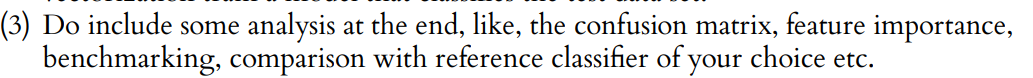

**Confusion matrix**

In [81]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(ran_pred, y_test)
print(conf_mat)

[[5 0 0 0 0 0 0 1 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 1 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


In [82]:
conf_mat = confusion_matrix(svm_pred, y_test)
print(conf_mat)

[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 4 0 1 0 1]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 1 0 0 0 0 4]]


In [83]:
conf_mat = confusion_matrix(dec_pred, y_test)
print(conf_mat)

[[5 0 0 0 0 0 0 1 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 1 0 0]
 [0 0 1 4 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 1 0 0 3 0 0 0 1]
 [0 0 0 0 0 0 4 0 0 0]
 [0 0 0 1 0 0 0 3 0 0]
 [0 0 0 0 0 0 1 0 5 0]
 [0 0 0 0 0 1 0 0 0 4]]


In [84]:
conf_mat = confusion_matrix(knn_pred, y_test)
print(conf_mat)

[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 3 0 1 0 0 0 0 0]
 [0 0 1 4 0 0 0 1 0 0]
 [0 0 0 0 4 0 0 0 0 0]
 [0 0 1 0 0 4 0 0 0 1]
 [0 0 0 0 0 0 5 0 3 0]
 [0 0 0 1 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 4]]


**Comparison of the classifiers**

We can see that <b>Random Forest</b> and <b>SVM</b> classifiers give one of the best accuracies of <b>94%</b> and <b>92%</b> respectively. <b>Decision Tree</b> and <b>KNN</b> classifiers give less accuracies of <b>80%</b> each. Hence we can select Random Forest or SVM as our final model.

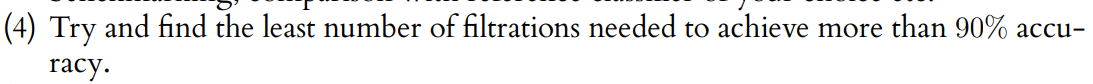

We have applied Height Filtration and Radial Filtration and have used Cubical Persistence and these were enough to achieve accuracy more than 90%.